<img src="pds_banner.png" style="height:200px">


# Laboratorio 8 Procesamiento de señales 2019-1

# Filtros con respuesta finital al impulso (FIR)

## Universidad de Antioquia


Material de apoyo para este laboratorio (MUY IMPORTANTE)

https://github.com/unpingco/Python-for-Signal-Processing/blob/master/Filtering_Part2.ipynb

Este tipo de filtros digitales se caracterizan porque su respuesta a la señal impulso tiene un número finito de componentes.

La salida del filtro FIR se obtiene unicamente a partir de sus respuesta natural y de su entrada en $M$ tiempos anteriores (ver ecuación \).

$$y[n]=\sum_{k=0}^{M-1}h[k]\cdot x[n-k]$$

Una de las metodologías de diseño para los filtros FIR es la del método del enventanando a partir de la respuesta ideal (filtros de función seno sobre su argumento ($Sa$ o $sinc$). En este caso se parte de un filtro ideal, el cual tendría ganancia $0$ en las bandas rechazadas, y ganancia $1$ en la banda de paso. Esta respuesta ideal en magnitud se muestra en la figura 

<img src="https://upload.wikimedia.org/wikipedia/commons/2/2d/TipoFiltro.png"
width="500"
align="middle" >


Se puede obtener la respuesta al impulso como la transformada inversa de Fourier de esta respuesta en frecuencia, la cual en este caso es una función seno sobre su argumento ($Sa$ o $sinc$), que tiene la figura

<img src="https://www.researchgate.net/profile/Cesar_Azurdia-Meza/publication/273681692/figure/fig7/AS:294774415347731@1447291105986/General-sinc-pulse-in-the-time-and-frequency-domain.png"
width="500"
align="middle" >



Como podemos observar, en primer lugar el sistema no sería causal, pues tiene componentes para muestras en tiempo negativo. Por otra parte, se requieren infinitas muestras para representar esta respuesta. Se concluye que es imposible obtener un filtro ideal. Sin embargo, es posible acercarse a esta respuesta.

Para ello, en primer lugar, una vez escogido el orden del filtro, se realiza un enventanado de la $Sa$ para hacer que sus muestras por encima y por debajo de cierto valor sean 0, es decir que ya no se extiende infinitamente en el tiempo. A continuación, se hace un corrimiento de esta señal para garantizar que sea causal. 

Esta metodología ya se había observado en la práctica, donde se utilizó la función ```signal.firwin``` para generar un filtro FIR. Recordemos que a medida que se aumentaba el orden del filtro y la respuesta en frecuencia iba tendiendo a la ideal, la respuesta al impulso tendía a una función $Sa$.


### Diseño del filtro FIR

Para diseñar un filtro FIR a partir de ciertas especificaciones dadas de frecuencias de corte ($f_c$), frecuencia de muestreo ($f_s$), ancho de banda en la transición ($\mathrm{BW}$),  ganancia (AdB), se sigue el siguiente procedimiento.

1. Se normalizan las frecuencias de corte, y se pasan a rad/s de acuerdo con la expresion: $w_c=2\pi\cdot f_c/f_s$
    
2. Se realiza el mismo procedimiento para el ancho de banda de transición: $\mathrm{BW}_n=2\pi\cdot \mathrm{BW}/f_s$.
    
3. Una regla práctica para determinar el orden del filtro es dividir 4 por el ancho de banda normalizado y tomar la parte entera del resultado, asi: $M=int(4/\mathrm{BW}_n)$.

4. Se calcula respuesta al impulso del filtro ideal de acuerdo con las siguientes ecuaciones
    
   **Respuesta filtro ideal**                                                                                          **Tipo de Filtro**
  ------------------------------------------------------------------------------------------------------------------- --------------------
   $h_1=\frac{\omega_c}{\pi}S_a(\frac{\omega_c n}{\pi})$                                                              Pasa--bajas
   
  $h_1=-\frac{\omega_c}{\pi}S_a(\frac{\omega_c n}{\pi})$                                                              Pasa--altas
  
  $h_1=\frac{\omega_{c2}}{\pi}S_a(\frac{\omega_{c2} n}{\pi})-\frac{\omega_{c1}}{\pi}S_a(\frac{\omega_{c1} n}{\pi})$   Pasa--banda
  
  $h_1=\frac{\omega_{c1}}{\pi}S_a(\frac{\omega_{c1} n}{\pi})-\frac{\omega_{c2}}{\pi}S_a(\frac{\omega_{c2} n}{\pi})$   Rechaza--banda
  

Donde $n$ es un vector de tiempo (muestras) que va desde $-M$ hasta $M$ (```n = np.arange(-M,M)```).
    
5. En el caso de filtros pasa--altas, pasa--bandas,  y rechaza--banda, adicionalmente se debe truncar la respuesta en el origen, de la siguiente forma.

    ```
    h1[n==0]=1-(wc)/np.pi # cuando es pasa--altas
    h1[n==0]=(wc2-wc1)/np.pi # cuando es pasabanda
    h1[n==0]=1-(wc2-wc1)/np.pi # cuando es rechazabanda
    ```
Al utilizar un número finito de muestras (M) en la respuesta del filtro, se genera un truncamiento que produce lóbulos laterales en la respuesta en frecuencia y un comportamiento oscilatorio cerca del líımite de la banda de paso (Fenómeno de Gibbs).
    


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from ztrans import *

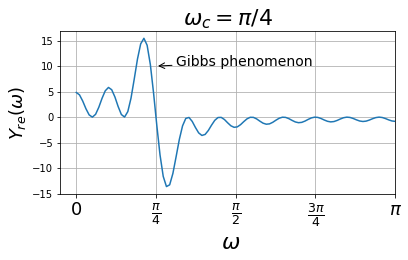

In [28]:
wc = np.pi/4
M=20

fig,ax = plt.subplots()
fig.set_size_inches(6,3)

k=np.arange(M)
omega = np.linspace(0,np.pi,100)
H=(np.sin(k*omega[:,None]+k*wc)-np.sin(k*omega[:,None]-k*wc)).sum(axis=1)
ax.plot(omega,H)
ax.set_ylabel(r"$Y_{re}(\omega)$",fontsize=18)
ax.grid()
ax.set_title(r"$\omega_c = \pi/4$",fontsize=22)
ax.set_xlabel(r" $\omega $",fontsize=22)
ax.set_xticks([0, np.pi/4,np.pi/2.,3*np.pi/4, np.pi,])
ax.set_xticklabels(['$0$',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$', r'$\pi$'],fontsize=18)
ax.set_xlim(xmax=np.pi)
ax.annotate("Gibbs phenomenon",xy=(np.pi/4,10),fontsize=14,
            xytext=(20,0),
            textcoords='offset points',
            arrowprops={'facecolor':'b','arrowstyle':'->'})
plt.show()


6. Para mitigar el fenómeno de Gibbs se utilizan ventanas diferentes a la rectangular, caracterizadas por no tener cambios abruptos en el dominio del tiempo, lo que conduce a lóbulos menores en el dominio de la frecuencia. Algunas ventanas típicas y sus características se presentan en la tabla
    
| Ventana              |                                                 Ecuación |
|----------------------|---------------------------------------------------------:|
| Barlett              |         $1-\frac{2 \left| n-\frac{M-1}{2}\right |}{M-1}$ |
| Hamming              |           $0.54-0.46\cos\left(\frac{2\pi n}{M-1}\right)$ |
| Hanning              | $0.5\left( 1-\cos\left(\frac{2\pi n}{M-1}\right)\right)$ |

Genere una de las ventanas anteriores de tamaño igual a la respuesta natural obtenida. Por ejemplo una ventana de Hamming
   
   ```win= signal.hamming(len(n))```
    
7. Multiplique la respuesta del filtro ideal obtenida, por la ventana escogida 

$$h_2[n]=h_1[n]*\mathrm{win[n]}$$
    
8. Finalmente multiplique la respuesta al impulso por la ganancia que se desea del filtro:  $h_2=h_2*A$, donde $A$ se calcula como $$A=np.sqrt(10**(0.1*A_{db}))$$
    


A continuacion, un ejemplo del diseño de un filtro pasa--bajas de 1 kHz, con una ganancia de 0dB, y u ancho de banda de transición de 200\,Hz.

## Ejemplo filtro pasabajas a 1000 Hz

### Consideraciones iniciales

In [30]:
fc=1000.0 # frec de corte
fs=8000.0 # frec de muestreo
Adb=0 # Ganancia del filtro en decibeles
N = 512 # Numero de puntos de la FFT
BW=200 # Ancho de banda en la banda de transicion

### Diseño del filtro

In [32]:
# 1. frecuencia de corte normalizada en radianes
wc = 2*np.pi*fc/fs  

# 2. ancho de banda  normalizado en radianes
bwn=2*np.pi*BW/fs                      

# 3. orden estimado del filtro
M=int(4/bwn)                           
print('El orden del filtro es: ', M)

# 4. Respuesta del filtro ideal h1[n]
n = np.arange(-M,M)
h1 = +wc/np.pi * np.sinc(wc*(n)/np.pi) # filtro pasabajas, recuerde cambiar cuando pasaaltas, pasabanda, o rechazabanda
w1,Hh1 = signal.freqz(h1,1,whole=True, worN=N) # Respuesta en frecuencia del filtro ideal

# 5. Truncamiento de frecuencie en el origen h1[0]

# Para el caso del filtro pasbajas no se debe aplicar

# 6. Generación de la ventana para elimnar el fenomeno de Gibbs
win= signal.hamming(len(n)) 

# 7. Multiplico la respuesta ideal por la ventana
h2=h1*win 


# 8. Ganancia del filtro
A=np.sqrt(10**(0.1*Adb))
h2=h2*A # Ganancia del filtro
w2,Hh2 = signal.freqz(h2,1,whole=True, worN=N) # Respuesta en frecuencia del filtro enventanado


u=np.ones_like(n) # escalon
un=np.convolve(u, h2, mode='full') # respuesta al escalon


El orden del filtro es:  25


## Graficas

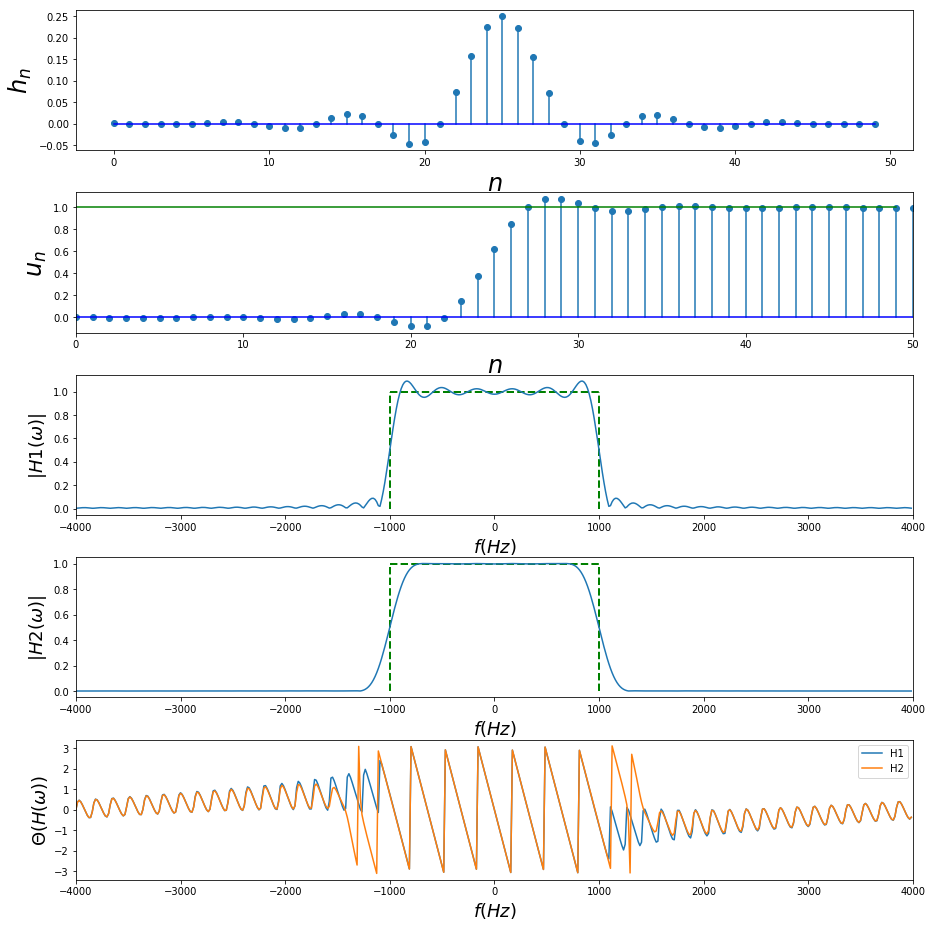

In [33]:
fig1,axs1 = plt.subplots(5,1)
fig1.set_size_inches((15,16))
subplots_adjust(hspace=0.3)

# respuesta natural 
ax=axs1[0]
ax.stem(n+M,h2,basefmt='b-')
ax.set_xlabel("$n$",fontsize=24)
ax.set_ylabel("$h_n$",fontsize=24)

# respuesta al escalon 
ax=axs1[1]
ax.stem(un,basefmt='b-')
ax.plot(u, color='g')
ax.set_xlabel("$n$",fontsize=24)
ax.set_ylabel("$u_n$",fontsize=24)
ax.axis(xmax=M*2,xmin=0)

# respuesta en frecuencia antes del enventanado 
ax=axs1[2]
ax.plot((w1-np.pi)*fs/(2*np.pi),np.abs(np.fft.fftshift(Hh1)))
ax.axis(xmax=fs/2,xmin=-fs/2)
ax.vlines([-fc,fc],0,1,color='g',lw=2.,linestyle='--')
ax.hlines(1,-fc,fc,color='g',lw=2.,linestyle='--')
ax.set_xlabel(r"$f (Hz)$",fontsize=18)
ax.set_ylabel(r"$|H1(\omega)| $",fontsize=18)

# respuesta en frecuencia despues del enventanado 
ax=axs1[3]
ax.plot((w2-np.pi)*fs/(2*np.pi),np.abs(np.fft.fftshift(Hh2)))
ax.axis(xmax=fs/2,xmin=-fs/2)
ax.vlines([-fc,fc],0,1,color='g',lw=2.,linestyle='--')
ax.hlines(1,-fc,fc,color='g',lw=2.,linestyle='--')
ax.set_xlabel(r"$f (Hz)$",fontsize=18)
ax.set_ylabel(r"$|H2(\omega)| $",fontsize=18)

ax=axs1[4]
ax.plot((w1-np.pi)*fs/(2*np.pi),np.angle(np.fft.fftshift(Hh1)))
ax.plot((w2-np.pi)*fs/(2*np.pi),np.angle(np.fft.fftshift(Hh2)))
ax.axis(xmax=fs/2,xmin=-fs/2)
ax.set_xlabel(r"$f (Hz)$",fontsize=18)
ax.set_ylabel(r"$\Theta(H(\omega)) $",fontsize=18)
ax.legend(['H1', 'H2'])

## Respuesta del filtro ante una señal con dos tonos

$$x[n]=\sin(2\pi*300*n)+\sin(2\pi*3000*n)$$

In [61]:
fs=8000
Tmax=4
NFFT=512
# señal en el tiempo $
t = np.arange(0,Tmax, 1/fs)
x = np.sin(2*np.pi*300*t)+np.sin(2*np.pi*3000*t)
X = np.fft.fft(x,NFFT)
# salida del filtro
y=np.convolve(x, h2)
Y = np.fft.fft(y,NFFT)

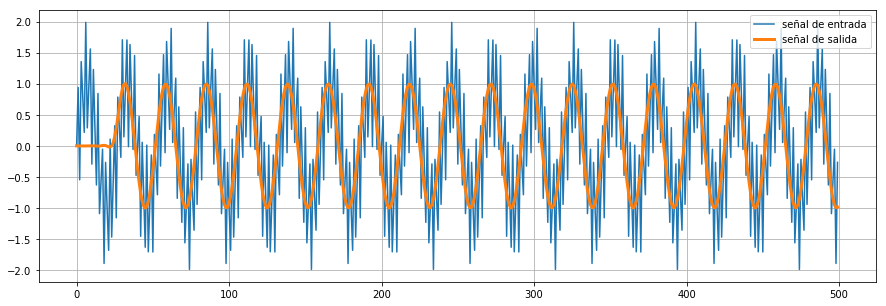

In [62]:

plt.figure(figsize=(15,5))
plt.plot(x[0:500], label="señal de entrada")
plt.plot(y[0:500], linewidth=3, label="señal de salida")
plt.legend()
plt.grid()

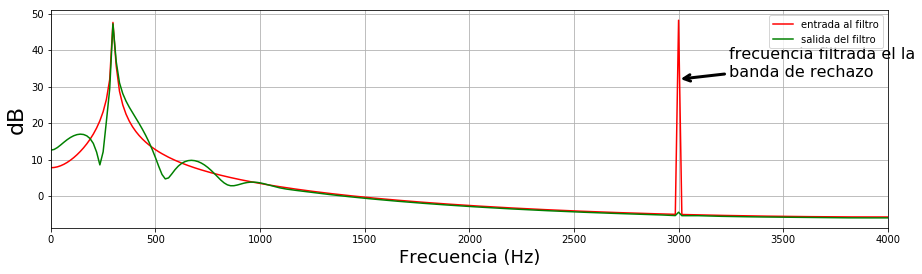

In [65]:
fig,ax = plt.subplots()
fig.set_size_inches((15,4))
ax.plot(np.arange(NFFT)/NFFT*fs,20*np.log10(np.abs(X)),'r-',label='entrada al filtro')
ax.plot(np.arange(NFFT)/NFFT*fs,20*log10(np.abs(Y)),'g-',label='salida del filtro')
ax.set_xlim(xmin=0, xmax = fs/2)
ax.set_ylabel(r'dB',fontsize=22)
ax.set_xlabel("Frecuencia (Hz)",fontsize=18)
ax.grid()
ax.annotate('frecuencia filtrada el la\nbanda de rechazo',fontsize=16,xy=(3000,32),
             xytext=(50,3),textcoords='offset points',
             arrowprops=dict(arrowstyle='->',lw=3),
            )
ax.legend(loc=0);

De acuerdo con los pasos anteriores, y el ejemplo suministrado realice el siguiente procedimiento.

### Procedimiento

1. Diseñe un filtro FIR con las siguientes características, de acuerdo con el último dígito de su cédula.

    Dígito     Filtro
  ------------ ------------------------------------------------------------------
       0       Pasa--bajas, fc=8kHz, fs=44.1kHz, BW=500Hz, AdB=0
       1       Pasa--altas, fc=60Hz, fs=200Hz, BW=3Hz, AdB=10
       2       Pasa--banda, fc1=1kHz, fc2=4kHz, fs=16kHz, BW=200Hz, AdB=0
       3       Rechaza--banda, fc1=700Hz y fc2=740Hz, fs=4kHz, BW=20Hz, AdB=5dB
       4       Pasa--altas, fc=50Hz, fs=400Hz, BW=10Hz, AdB=0
       5       Pasa--bajas, fc=4kHz, fs=16kHz, BW=200Hz, AdB=10
       6       Pasa--altas, fc=240Hz, fs=4kHz, BW=50Hz, AdB=0
       7       Pasa--banda, fc1=500Hz, fc2=1000Hz, fs=8kHz, BW=100Hz, AdB=0
       8       Rechaza--banda, fc1=520Hz, fc2=580Hz, fs=4kHz, BW=30Hz, AdB=0dB
       9       Pasa--altas, fc=250Hz, fs=4kHz, BW=20Hz, AdB=0

2. Cuál es el orden del filtro estimado con el ancho de banda. ¿Qué puede decir acerca de dicho orden? Cuales son las ventajas y desventajas de que sea grande o pequeño.
    

3.  Grafique la respuesta al impulso del filtro obtenido ($h_2$ de acuerdo con la notación usada). ¿Qué puede observar?

4. Grafique la respuesta al escalón del filtro obtenido. ¿Qué puede observar y concluir?

5. Grafique la respuesta en frecuencia del filtro de amplitud y fase antes de multiplicar por la ventana ($Hh_1$). ¿Qué se puede concluir?

6. Grafique la respuesta en frecuencia del filtro de amplitud y fase después de multiplicar por la ventana ($Hh2$). ¿Qué se puede concluir?